EAE3709 Aplicaciones de Machine Learning en Economía <br>
Primer Semestre 2025

Instituto de Economía<br>
Pontificia Universidad Católica de Chile
# Proyecto Final: “¿Existen perfiles similares de bienestar subjetivo que comparten los países de la OCDE?”
- Autores:
    - Valentina Flores  [vale.flores@uc.cl]
    - Ignacio Maluenda  [limaluenda@uc.cl]
    - Constanza Muñoz  [camunoz52@uc.cl]
    
- Fecha: [30 de junio, 2025]
__________________________________________________________

## Descripción del proyecto

El concepto de bienestar subjetivo, entendido como la percepción individual sobre la calidad de vida, ha ganado relevancia en las últimas décadas como un indicador clave del desarrollo social, complementario a las métricas económicas tradicionales como el Producto Interno Bruto per cárpita (PIB) . En este estudio, se aplican técnicas de Machine Learning bajo un contexto de aprendizaje no supervisado para evaluar si es posible encontrar relaciones entre los países según el nivel de bienestar utilizando el "Better Life Index"  de la OCDE, este recopila indicadores objetivos por país —como ingreso, salud, educación, empleo, vivienda y seguridad — con lo que se construye una medida subjetiva de satisfacción de vida. Esto podría aportarnos información valiosa para la formulación de políticas públicas y el análisis comparado del desarrollo social.
Resumen:
- Área(s) de aplicación: Economía (Desarrollo económico y economía del bienestar), políticas públicas  .
- Tipo de aprendizaje: No supervisado.
- Tipo de problema: Clustering.
- Fuente principal: OCDE Better Life Index (2024). https://www.oecdregionalwellbeing.org/
- Variable objetivo: No aplica.
- Atributos explicativos principales: ingresos, empleo, educación, salud, balance vida-trabajo, medio ambiente, seguridad, compromiso cívico, conexiones sociales.
- Número estimado de observaciones totales: 38 países y sus regiones (miembros OCDE y asociados). En total son 6248 observaciones.


## Contenido
1. [Pre-procesamiento](#seccion1)
2. [Análisis Exploratorio de Datos (EDA)](#seccion2)
3. [Feature Engineering](#seccion3)
4. [Entrenamiento / Clustering](#seccion4)
5. [Evaluación](#seccion5)
__________________________________________________________

## 1. Pre-procesamiento <a name="seccion1"></a>
En esta sección:
- Importación de librerías principales
- Carga del data frame
- Integración con otros sets de datos (si aplica)
- Descripción inicial de las columnas:
    - tipo de datos
    - evaluar presencia de missings y outliers

In [1]:
#importacion de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
#carga de dataframe
url = "https://raw.githubusercontent.com/constanzaamunoz/Proyecto-clustering/main/dataset.csv"
df = pd.read_csv(url)
df.head()

,Country,Region,Code,Education,Jobs,Income,Safety,Health,Environment,Civic engagement,Accessiblity to services,Housing,Community,Life satisfaction
0,Australia,New South Wales,AU1,8.5,8.2,5.7,9.8,9.5,7.6,10.0,5.4,7.9,8.9,8.5
1,Australia,Victoria,AU2,8.5,8.4,4.6,9.8,9.9,8.3,10.0,5.5,9.6,8.9,8.8
2,Australia,Queensland,AU3,8.2,8.3,5.0,9.8,9.2,9.3,10.0,5.3,7.9,7.1,8.1
3,Australia,South Australia,AU4,7.6,8.1,5.3,9.9,9.1,9.6,10.0,4.9,7.9,8.4,8.5
4,Australia,Western Australia,AU5,8.2,8.9,5.9,9.8,9.6,8.5,10.0,5.2,9.6,7.6,8.5


In [3]:
#carga de dataframe modificada manualmente, data a utilizar en el análisis
# Se ha modificado la data para eliminar missing values.
url_excel = "https://raw.githubusercontent.com/constanzaamunoz/Proyecto-clustering/main/dataset.xlsx"
df_mod = pd.read_excel(url_excel, sheet_name=2)
df_mod.head()

,Country,Region,Code,Education,Jobs,Income,Safety,Health,Environment,Civic engagement,Accessiblity to services,Housing,Community,Life satisfaction
0,Australia,New South Wales,AU1,8.5,8.2,5.7,9.8,9.5,7.6,10.0,5.4,7.9,8.9,8.5
1,Australia,Victoria,AU2,8.5,8.4,4.6,9.8,9.9,8.3,10.0,5.5,9.6,8.9,8.8
2,Australia,Queensland,AU3,8.2,8.3,5.0,9.8,9.2,9.3,10.0,5.3,7.9,7.1,8.1
3,Australia,South Australia,AU4,7.6,8.1,5.3,9.9,9.1,9.6,10.0,4.9,7.9,8.4,8.5
4,Australia,Western Australia,AU5,8.2,8.9,5.9,9.8,9.6,8.5,10.0,5.2,9.6,7.6,8.5


#### DESCRIPCIÓN DE LAS VARIABLES

La base de datos utilizada proviene del OECD Regional Well-Being Index que incluye información de más de 400 regiones pertenecientes a países miembros de la OCDE. Cada observación representa una región identificada por el país, el nombre de la región. La base contiene 11 indicadores normalizados entre 0 y 10 que miden dimensiones clave del bienestar objetivo, además de una medida subjetiva de bienestar general calculada por la organización.

Los indicadores incluidos son:

* Education: Nivel educativo promedio, medido como la proporción de adultos con al menos educación secundaria.

* Jobs: Indicador del mercado laboral, que considera tasas de empleo y desempleo.

* Income: Ingreso disponible per cápita ajustado por paridad de poder de compra.

* Safety: Nivel de seguridad, aproximado por la tasa de homicidios.

* Health: Esperanza de vida al nacer, como proxy del estado de salud.

* Environment: Calidad del aire medida por concentración de material particulado fino.

* Civic engagement: Participación electoral como medida de compromiso cívico.

* Accessiblity to services: Porcentaje de hogares con acceso a internet de banda ancha.

* Housing: Indicador de condiciones de vivienda.

* Community: Nivel de apoyo social percibido.

* Life satisfaction: Medida subjetiva de satisfacción con la vida.

Estas variables buscan representar múltiples dimensiones del bienestar de forma comparable entre regiones.

-------

#### EVALUAMOS LA PRESENCIA DE OUTLIERS Y MISSINGS VALUES

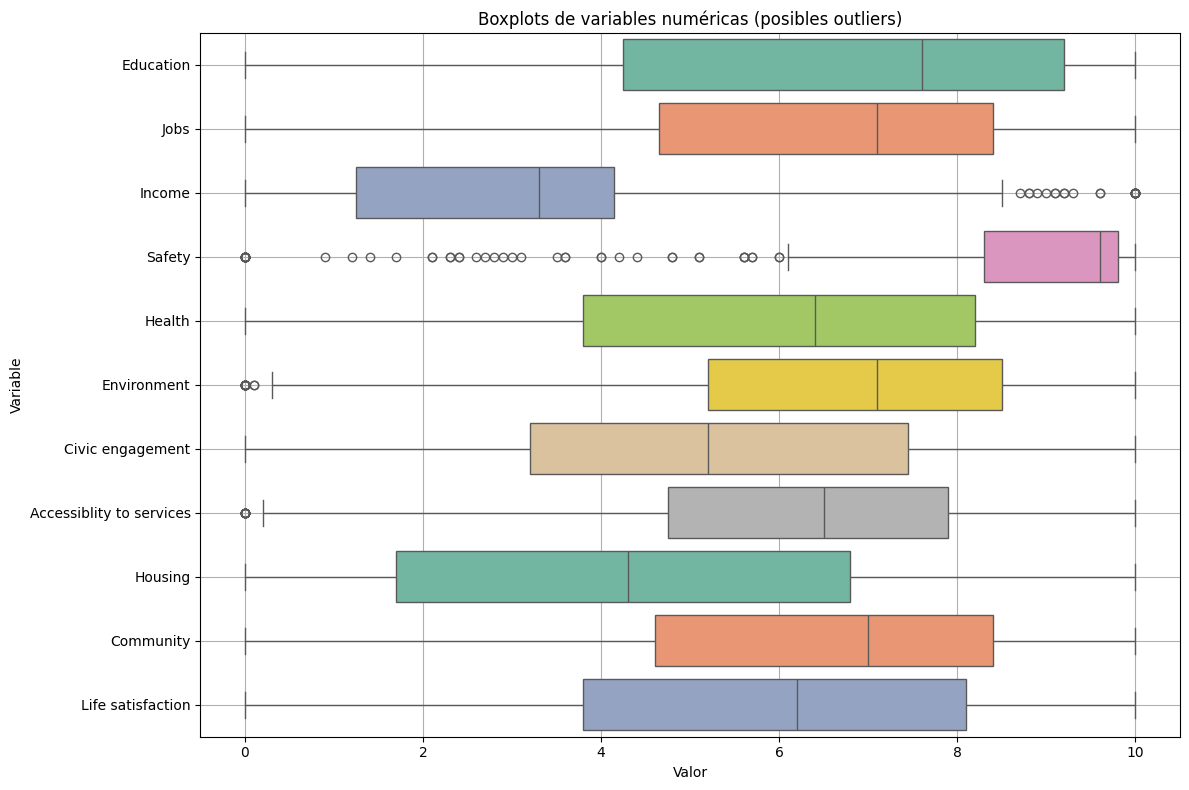

In [4]:
# Outliers
df_numeric = df_mod.select_dtypes(include='number')

df_long = df_numeric.melt(var_name='Variable', value_name='Valor')

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_long, x='Valor', y='Variable', orient='h', palette="Set2", hue='Variable')
plt.title('Boxplots de variables numéricas (posibles outliers)')
plt.xlabel('Valor')
plt.ylabel('Variable')
plt.grid(True)
plt.tight_layout()
plt.show()


Se pueden observar valores atípicos (outliers) en los gráficos de caja. Variables como Income, Safety, Environment y Accesibility to Services tienen outliers. En el caso de Income se puede deber a a la presencia de economías con sgnificativos mayores ingresos. Safety tiene una caja estrecha, por lo que se podría deducir que varios pasíses tienen percepciones similares de seguridad pero tiene muchos valores atípicos en los datos, presenta una gran variabilidad. También nos podría estar indicando una desigualdad atípica en la región.

La decisión de imputar o no los outliers depende de si estos valores extremos representan errores o, por el contrario, fenómenos reales y significativos. Dado que se trabaja con datos de indicadores sociales y económicos por país/región, es razonable suponer que los outliers podrían reflejar características estructurales reales de ciertos países, como un ingreso extremadamente alto, una seguridad excepcionalmente baja, etc. En ese caso, eliminarlos o imputarlos podría ocultar información relevante sobre las condiciones reales, por lo que se decide no hacerlo. 

En la siguiente tabla se puede ver un conteo de los datos que faltan por variable. Las que tienen más missing value son las variables de Educación, Trabajo e Ingreso, así que hay varias regiones que no entregaron esa info. Las demás están casi completas dentro de la base de datos, con solo un par de vacíos.

In [5]:
# Contar missing values de la data original
indicadores = df.columns.difference(['Country', 'Region', 'Code'])
missing_values = df[indicadores].isnull().sum()
missing_values[missing_values > 0]

Civic engagement      1
Community            10
Education            24
Housing               3
Income               12
Jobs                 15
Life satisfaction    10
Safety                3
dtype: int64

## 2. Análisis Exploratorio de Datos <a name="seccion2"></a>
En esta sección:
- Análisis descriptivo de cada variable
    - Distribución variables contínuas
    - Conteo de presencia de cada estado en variables categóricas
- Decisiones de imputación de missings y depuración de outliers

#### ANÁLISIS DESCRIPTIVO DE LAS VARIABLES 

In [6]:
df_mod[list(indicadores)].describe()

,Accessiblity to services,Civic engagement,Community,Education,Environment,Health,Housing,Income,Jobs,Life satisfaction,Safety
count,447.000000,447.000000,447.000000,435.000000,447.000000,447.000000,445.000000,447.000000,447.000000,437.000000,447.000000
mean,6.092394,5.205145,6.308501,6.530115,6.587919,5.843400,4.491685,3.386577,6.368904,5.931350,8.484116
std,2.279060,2.831223,2.703198,3.104418,2.609922,2.757687,2.956539,2.565719,2.664969,2.760535,2.473336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.750000,3.200000,4.600000,4.250000,5.200000,3.800000,1.700000,1.250000,4.650000,3.800000,8.300000
50%,6.500000,5.200000,7.000000,7.600000,7.100000,6.400000,4.300000,3.300000,7.100000,6.200000,9.600000
75%,7.900000,7.450000,8.400000,9.200000,8.500000,8.200000,6.800000,4.150000,8.400000,8.100000,9.800000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


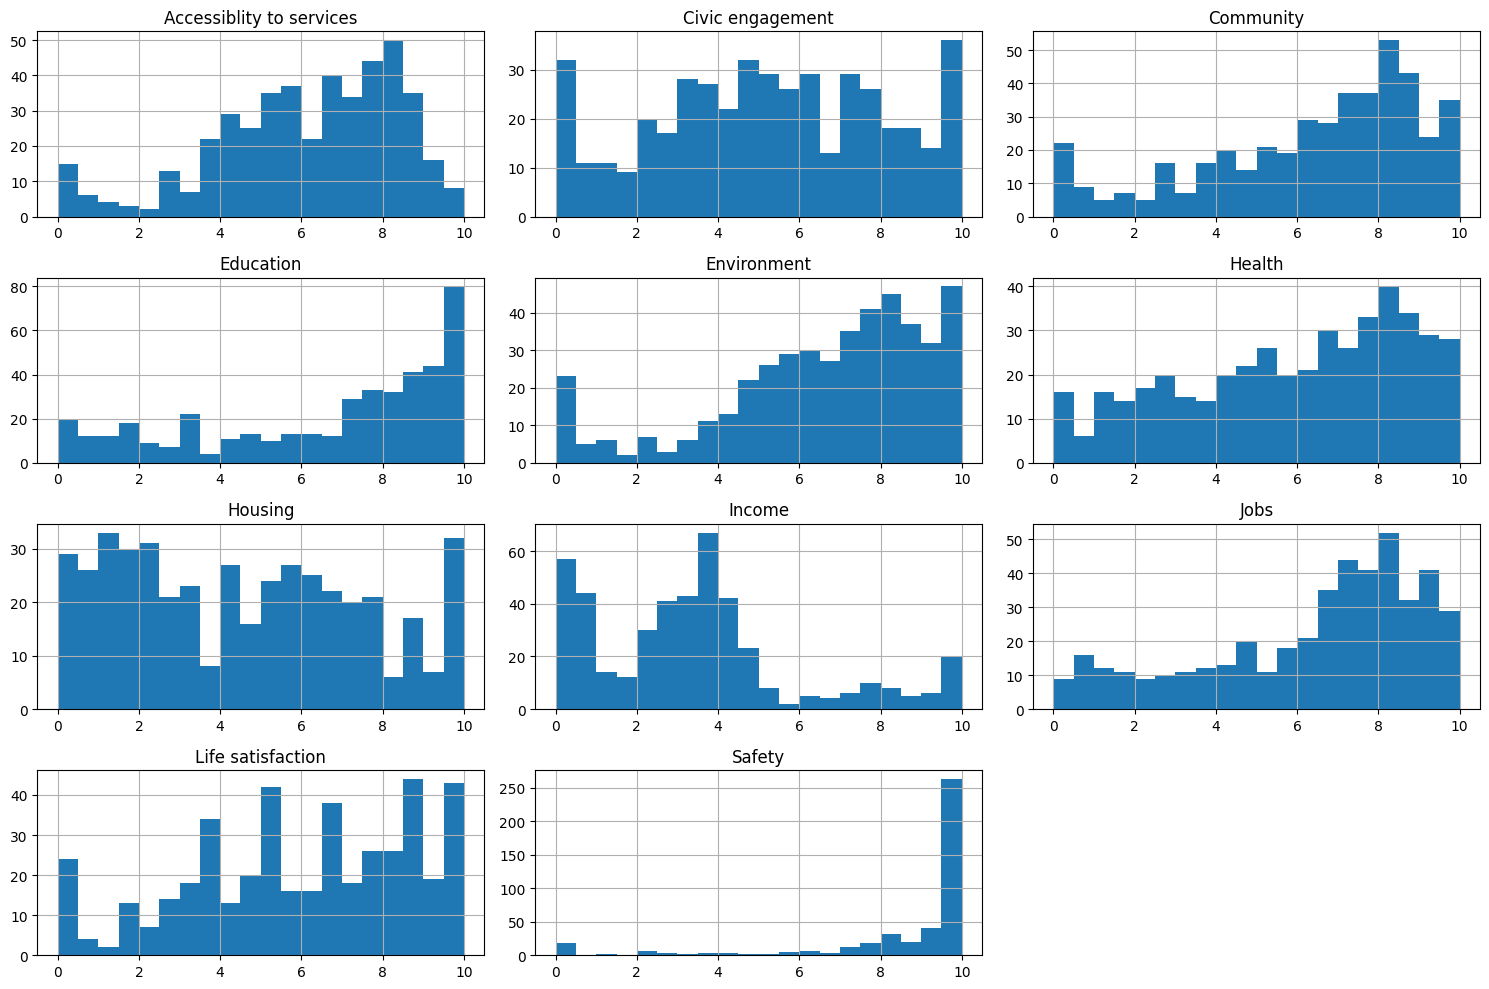

In [7]:
# Hitogramas
df_mod[list(indicadores)].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

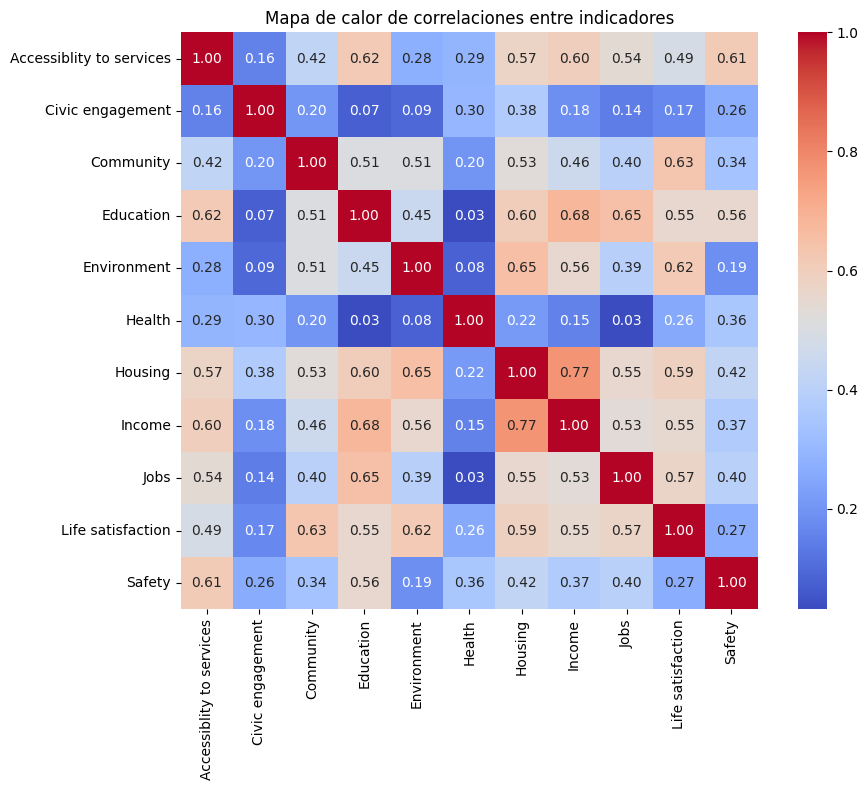

In [8]:
# Matriz de correlación
correlation_matrix = df_mod[indicadores].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Mapa de calor de correlaciones entre indicadores")
plt.tight_layout()
plt.show()


Viendo el mapa de calor, se nota que varias variables están correlacionadas entre sí. Por ejemplo, las variables Educación, Ingreso, Trabajo, Viviendas y Accesibilidad a servicios tienen alta correlación entre ellas, lo que tiene sentido porque todas apuntan a condiciones materiales de vida y correlacionan con la variable “Life Satisfaction”.  

Por eso tiene sentido aplicar un PCA. Al estar algunas variables tan relacionadas, el PCA nos va a ayudar a resumirlas en menos dimensiones sin perder tanta información. Así evitamos que las variables más parecidas “doble contabilizadas” cuando hagamos clustering, y además mantenemos variables como Health o Civic engagement que no están tan correlacionadas y podrían aportar algo distinto.

#### DECISIONES DE IMPUTACIÓN DE MISSING VALUES Y DEPURACIÓN DE OUTLIERS

----------

El Banco Mundial posee dos bases de datos, una con la información por región (sheet 1) y la otra con la información por país (sheet 2). Para los missing values faltantes en algunas regiones decidimos utilizar la información facilitada por la institución, la que corresponde a un promedio con la información que tenían en ese momento. Hay países como Japón e Islandia en donde no existían datos ni por región ni por país, por lo que quedaron como faltantes. Se creó la base de datos modificada manualmente (sheet 3) en la que se incorpora la información de los primeros dos dataset.


---------


In [9]:
#missing values data modificada
df_mod.isnull().sum() #Primero observamos qué datos tienen missing values.
df_mod.isnull().sum().sort_values(ascending=False)
total_missings = df_mod.isnull().sum().sort_values(ascending=False)
total_missings #observamos el ranking del total de missings por variable.
total_datos = df_mod.isnull().count()
total_datos #observamos el total de datos por variable.
percent_missings = (total_missings/total_datos).sort_values(ascending=False)*100
percent_missings #mostramos los missing values como un % del total de datos por variable.

Education                   2.684564
Life satisfaction           2.237136
Housing                     0.447427
Code                        0.000000
Civic engagement            0.000000
Accessiblity to services    0.000000
Country                     0.000000
Community                   0.000000
Health                      0.000000
Environment                 0.000000
Income                      0.000000
Jobs                        0.000000
Region                      0.000000
Safety                      0.000000
dtype: float64

In [10]:
df_mod = df_mod.fillna(df_mod.mean(numeric_only=True)) #reeemplazamos japón e islandia con los valores promedios de las columnas (es decir, ahora estamos usando el promedio mundial)
df_mod.isnull().sum()

Country                     0
Region                      0
Code                        0
Education                   0
Jobs                        0
Income                      0
Safety                      0
Health                      0
Environment                 0
Civic engagement            0
Accessiblity to services    0
Housing                     0
Community                   0
Life satisfaction           0
dtype: int64

In [11]:
df_mod  #verificamos que no hay más missing values

,Country,Region,Code,Education,Jobs,Income,Safety,Health,Environment,Civic engagement,Accessiblity to services,Housing,Community,Life satisfaction
0,Australia,New South Wales,AU1,8.5,8.2,5.7,9.8,9.5,7.6,10.0,5.4,7.9,8.9,8.5
1,Australia,Victoria,AU2,8.5,8.4,4.6,9.8,9.9,8.3,10.0,5.5,9.6,8.9,8.8
2,Australia,Queensland,AU3,8.2,8.3,5.0,9.8,9.2,9.3,10.0,5.3,7.9,7.1,8.1
3,Australia,South Australia,AU4,7.6,8.1,5.3,9.9,9.1,9.6,10.0,4.9,7.9,8.4,8.5
4,Australia,Western Australia,AU5,8.2,8.9,5.9,9.8,9.6,8.5,10.0,5.2,9.6,7.6,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,United States,Virginia,US51,9.5,8.3,9.3,8.4,5.1,9.1,6.6,8.5,9.4,8.3,6.2
443,United States,Washington,US53,9.5,7.6,10.0,9.0,6.1,9.4,7.2,8.0,8.1,7.3,8.1
444,United States,West Virginia,US54,9.2,7.0,6.6,8.3,0.7,9.0,3.1,7.2,10.0,10.0,8.1
445,United States,Wisconsin,US55,9.8,9.0,8.3,8.6,4.8,8.6,7.2,7.5,10.0,8.7,8.5


## 3. Feature Engineering <a name="seccion3"></a>
En esta sección se incluye:
- Transformaciones necesarias para su ingesta por parte de algoritmos ML:
    - Estandarización y escalado
    - Técnicas de reducción de dimensionalidad (PCA)

In [12]:
#Escalado de variable nueva 'PCA_material'
variables_correlacionadas = ['Education', 'Income', 'Jobs', 'Housing', 'Accessiblity to services']
print("Missing values before scaling:")
print(df_mod[variables_correlacionadas].isnull().sum())
df_mod = df_mod.fillna(df_mod.mean(numeric_only=True))
print("\nMissing values after filling and before scaling:")
print(df_mod[variables_correlacionadas].isnull().sum())
scaler = StandardScaler()
X_sub = scaler.fit_transform(df_mod[variables_correlacionadas])

Missing values before scaling:
Education                   0
Income                      0
Jobs                        0
Housing                     0
Accessiblity to services    0
dtype: int64

Missing values after filling and before scaling:
Education                   0
Income                      0
Jobs                        0
Housing                     0
Accessiblity to services    0
dtype: int64


In [13]:
# Reducción de dimensionalidad usando PCA

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_sub)
df_mod['PCA_material'] = X_pca

# juntamos variables
otras_variables = ['Health', 'Community', 'Civic engagement', 'Safety']
df_final = df_mod[['Country', 'Region', 'Code', 'PCA_material'] + otras_variables]

In [14]:
df_final.describe()

,PCA_material,Health,Community,Civic engagement,Safety
count,447.000000,447.000000,447.000000,447.000000,447.000000
mean,0.000000,5.843400,6.308501,5.205145,8.484116
std,1.857629,2.757687,2.703198,2.831223,2.473336
min,-3.725928,0.000000,0.000000,0.000000,0.000000
25%,-1.513963,3.800000,4.600000,3.200000,8.300000
50%,0.508730,6.400000,7.000000,5.200000,9.600000
75%,1.217282,8.200000,8.400000,7.450000,9.800000
max,3.494282,10.000000,10.000000,10.000000,10.000000


In [15]:
# Dataframe final estandarizar el resto de variables
df_cluster = df_final.drop(columns=['Country', 'Region', 'Code'])
scaler_total = StandardScaler()
X_sca = scaler_total.fit_transform(df_cluster)
df_f1 = pd.DataFrame(X_sca, columns=df_cluster.columns)
df_f1[['Country', 'Region', 'Code']] = df_final[['Country', 'Region', 'Code']].reset_index(drop=True)


In [16]:
# Dataframe final post estandarizar todas las variables
df_f1.describe().round(2)

,PCA_material,Health,Community,Civic engagement,Safety
count,447.00,447.00,447.00,447.00,447.00
mean,0.00,-0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.01,-2.12,-2.34,-1.84,-3.43
25%,-0.82,-0.74,-0.63,-0.71,-0.07
50%,0.27,0.20,0.26,-0.00,0.45
75%,0.66,0.86,0.77,0.79,0.53
max,1.88,1.51,1.37,1.70,0.61


## 4. Entrenamiento / Clustering <a name="seccion4"></a>
En esta sección:
- Modelo K-means: elbow method, silhouette score y clusters.
- Modelo GMM (Gaussian Mixture Models )

#### MODELO K-MEANS

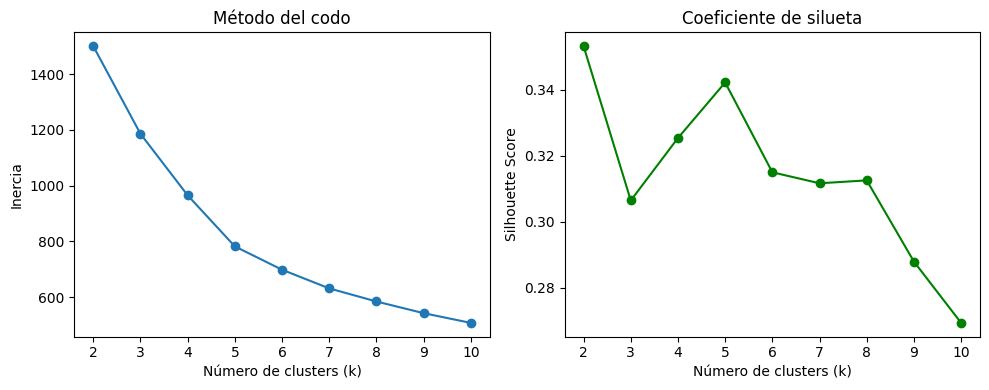

In [17]:
## Método del codo 
X_cluster = df_f1.drop(columns=['Country', 'Region', 'Code'])

inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans.labels_))


plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')

## Coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Coeficiente de silueta')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


 Se implementó el método del codo (elbow method), que consiste en graficar la suma de los errores cuadráticos dentro de los grupos en función del número de clusters k. El punto donde la disminución de la inercia comienza a estabilizarse sugiere una estructura natural en los datos, indicando un valor de k apropiado. En este análisis, se identificó que cinco clusters capturan adecuadamente la heterogeneidad presente en los datos. Además, se realizó un estudio utilizando el coeficiente de silueta, que nos muestra que aunque k=2 tiene el mayor coeficiente, en el contexto de análisis multivariado como el presente (con múltiples dimensiones del bienestar), elegir k=5 representa un compromiso razonable entre interpretabilidad, heterogeneidad de los grupos y calidad de segmentación. Esto permite capturar una mayor variedad de perfiles de países sin perder demasiada coherencia estructural 

c:\Users\const\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


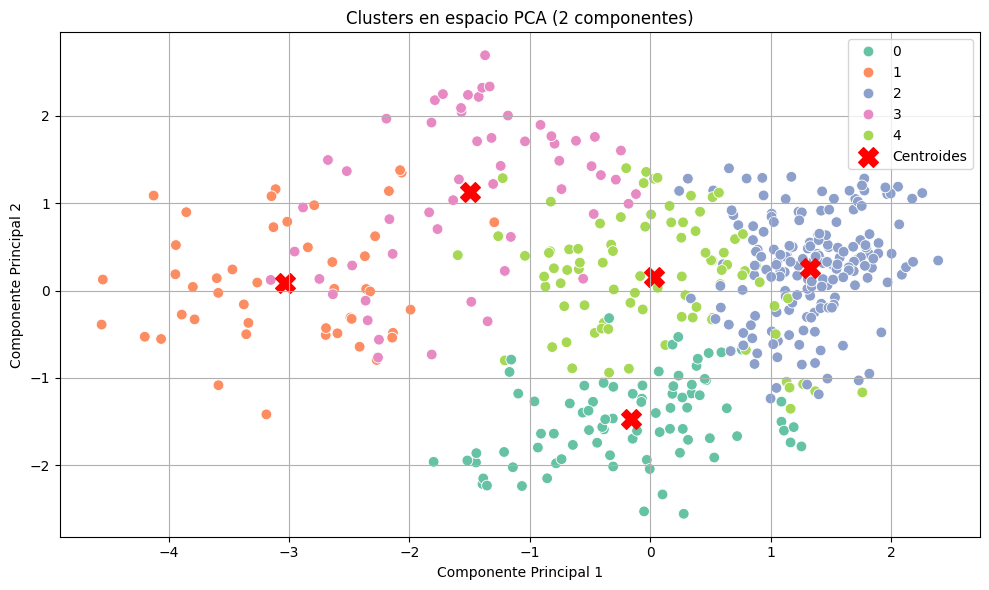

In [18]:
# k=5
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=10)
df_f1['cluster'] = kmeans_final.fit_predict(X_cluster)

# Asegurar solo columnas numéricas para PCA
X_cluster_numeric = X_cluster.select_dtypes(include='number')

# PCA a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_numeric)

# Centroides transformados al espacio PCA
centroids_pca = pca.transform(kmeans_final.cluster_centers_)

# Crear DataFrame para graficar
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_f1['cluster']
df_pca['Country'] = df_f1['Country']

# Scatterplot con centroides
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2', s=60)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Clusters en espacio PCA (2 componentes)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Pesos de las variables según los componentes pca
componentes = pd.DataFrame(
    pca.components_,
    columns=X_cluster.columns,
    index=["PC1", "PC2"]
).T
componentes_abs = componentes.abs()
componentes_abs.sort_values("PC1", ascending=False).head(5)
componentes_abs.sort_values("PC2", ascending=False).head(5)

,PC1,PC2
Health,0.357724,0.613219
Civic engagement,0.345486,0.552830
PCA_material,0.524313,0.408170
Community,0.463463,0.388218
Safety,0.512807,0.032028


In [20]:
# Silhouette de KMeans
silhouette_kmeans = silhouette_score(X_cluster, df_f1['cluster'])
print(f"Silhouette Score KMeans (k=5): {silhouette_kmeans:.4f}")

Silhouette Score KMeans (k=5): 0.3422


#### MODELO GMM

In [21]:
# Elegimos el mismo número de clusters para comparar
n_clusters = 5

# Entrenar modelo GMM
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_cluster)

# Calcular silhouette para GMM
silhouette_gmm = silhouette_score(X_cluster, gmm_labels)
print(f"Silhouette Score GMM (k=5): {silhouette_gmm:.4f}")

# Guardar en el DataFrame
df_f1['cluster_gmm'] = gmm_labels

Silhouette Score GMM (k=5): 0.2860


c:\Users\const\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


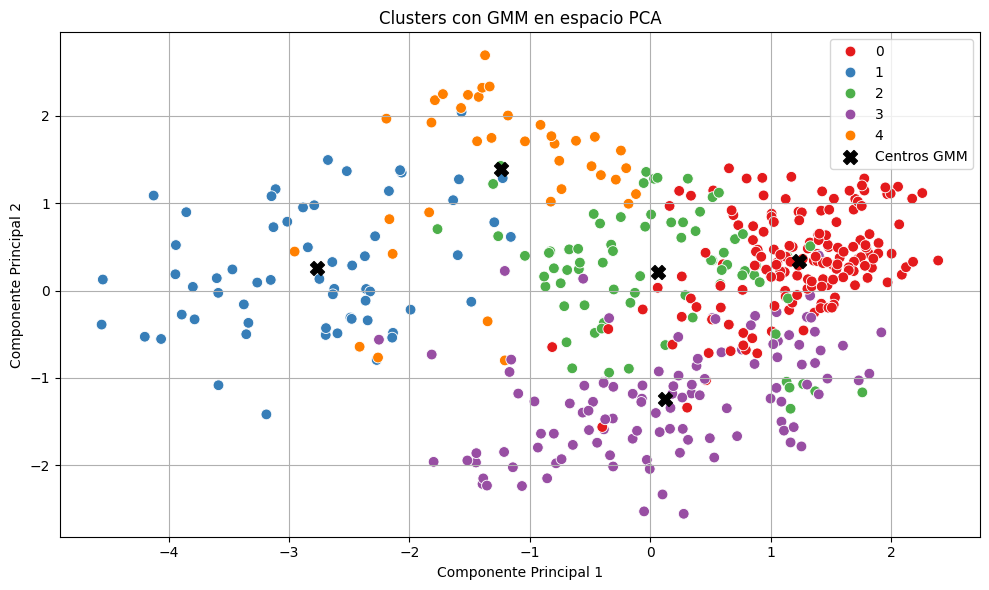

In [22]:
# Obtener medias de los componentes (centros GMM)
gmm_centers = gmm.means_

# Proyectar las medias al espacio PCA
gmm_centroids_pca = pca.transform(gmm_centers)

# Graficar clusters GMM y los centros
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_f1['cluster_gmm'], palette='Set1', s=60)
plt.scatter(gmm_centroids_pca[:, 0], gmm_centroids_pca[:, 1], 
            color='black', label='Centros GMM', s=100, marker='X')

plt.title("Clusters con GMM en espacio PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### COMPARACIÓN DE LOS MODELOS

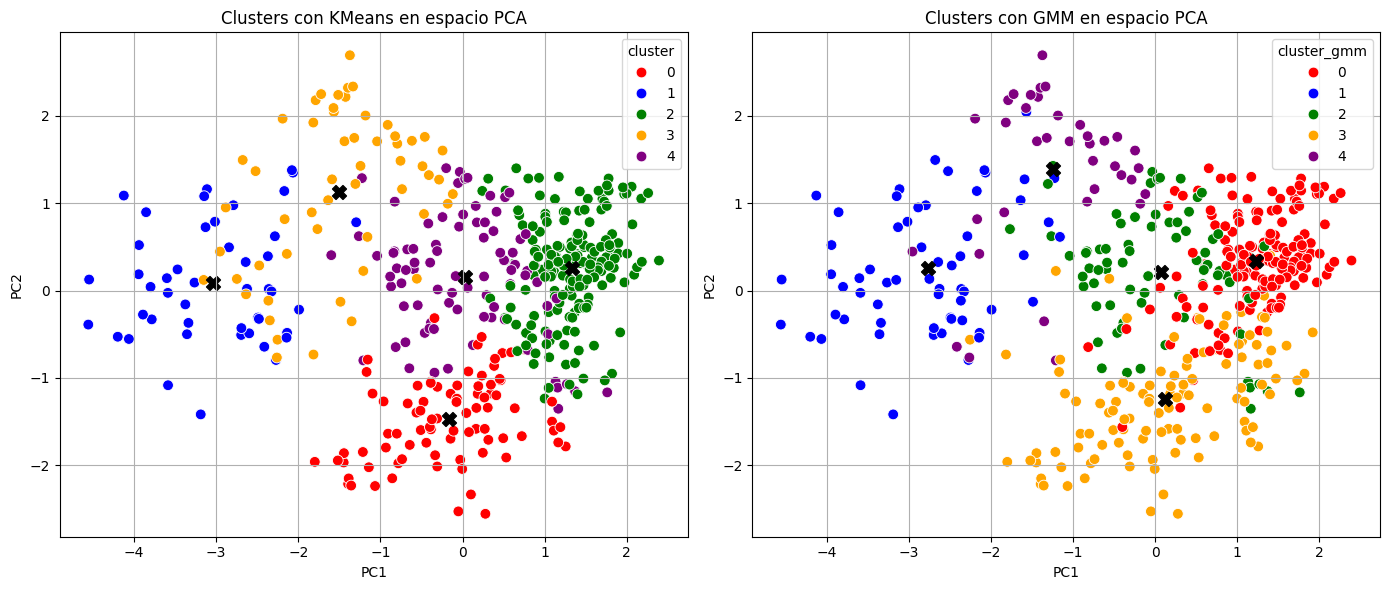

In [23]:
# Se define una paleta fija para clusters 0 a 4
paleta_fija = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "purple"}

fig, axs = plt.subplots(1, 2, figsize=(14,6))

# KMeans
sns.scatterplot(
    x=df_pca['PC1'], y=df_pca['PC2'],
    hue=df_f1['cluster'],
    palette=paleta_fija,
    s=60, ax=axs[0]
)
axs[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], color='black', marker='X', s=100, label='Centroides')
axs[0].set_title("Clusters con KMeans en espacio PCA")
axs[0].grid(True)

# GMM
sns.scatterplot(
    x=df_pca['PC1'], y=df_pca['PC2'],
    hue=df_f1['cluster_gmm'],
    palette=paleta_fija,
    s=60, ax=axs[1]
)
axs[1].scatter(gmm_centroids_pca[:, 0], gmm_centroids_pca[:, 1], 
            color='black', label='Centros GMM', s=100, marker='X')
axs[1].set_title("Clusters con GMM en espacio PCA")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [24]:
# Comparación Silhouette
print(f"\nComparación de modelos:")
print(f"KMeans Silhouette: {silhouette_kmeans:.4f}")
print(f"GMM Silhouette:    {silhouette_gmm:.4f}")


Comparación de modelos:
KMeans Silhouette: 0.3422
GMM Silhouette:    0.2860


In [25]:
# Tabla comparativa entre clusters KMeans y GMM 
# con este comando se puede saber que cluster de GMM es el que se parece a los de Kmeans
tabla_comparacion = pd.crosstab(df_f1['cluster'], df_f1['cluster_gmm'])
print(tabla_comparacion)


cluster_gmm    0   1   2   3   4
cluster                         
0              5   0   0  80   0
1              0  45   0   0   1
2            144   0   4  28   0
3              0  14   4   4  33
4             13   2  67   0   3


A partir de lo anterior se puede deducir que ambos algoritmos están capturando estructuras similares en los datos. La tabla permite mapear aproximadamente así:
| KMeans Cluster | GMM Más Similar |
| -------------- | --------------- |
| 0              | 3               |
| 1              | 1               |
| 2              | 0               |
| 3              | 4               |
| 4              | 2               |

En particular, al comparar los clusters obtenidos por los dos algoritmos, se observa que:

- El cluster 0 de KMeans se corresponde mayoritariamente con el cluster 3 de GMM (80 observaciones) y en menor medida con el cluster 0 (5 casos).
- El cluster 1 de KMeans coincide casi totalmente con el cluster 1 de GMM, mostrando gran estabilidad (45 observaciones en común).
- El cluster 2 de KMeans se distribuye principalmente en el cluster 0 de GMM (144 observaciones), pero también presenta un subgrupo en el cluster 3 (28 casos) y unos pocos en el cluster 2.
- El cluster 3 de KMeans queda repartido entre varios clusters de GMM: principalmente el cluster 4 de GMM (33 casos), seguido del cluster 1 (14 casos) y algunos puntos dispersos.
- Finalmente, el cluster 4 de KMeans se concentra sobre todo en el cluster 2 de GMM (67 observaciones), pero también presenta cierta dispersión hacia los clusters 0, 1 y 4.

Esto sugiere que GMM tiende a subdividir algunos grupos formados por KMeans, capturando posibles estructuras internas más complejas, aunque con un menor Silhouette Score, lo que indica menos separación y cohesión.

## 5. Evaluación <a name="seccion5"></a>
En esta sección:
- Promedio de variables por cluster en cada modelo. 
- Ventajas y desventajas de los modelos. 

In [26]:
## Promedios_clusters K means
columnas_numericas = ['PCA_material', 'Health', 'Community', 'Civic engagement', 'Safety']

promedios_cluster = df_f1.groupby('cluster')[columnas_numericas].mean()
print(promedios_cluster)

         PCA_material    Health  Community  Civic engagement    Safety
cluster                                                               
0            0.508059 -1.383307   0.314914         -0.525979  0.197859
1           -1.538710 -0.776538  -0.756723         -0.791270 -2.587588
2            0.634708  0.572516   0.610028          0.762439  0.474209
3           -1.318959 -0.405187  -1.477128          0.463004 -0.271019
4           -0.136122  0.880285  -0.212721         -0.924091  0.395956


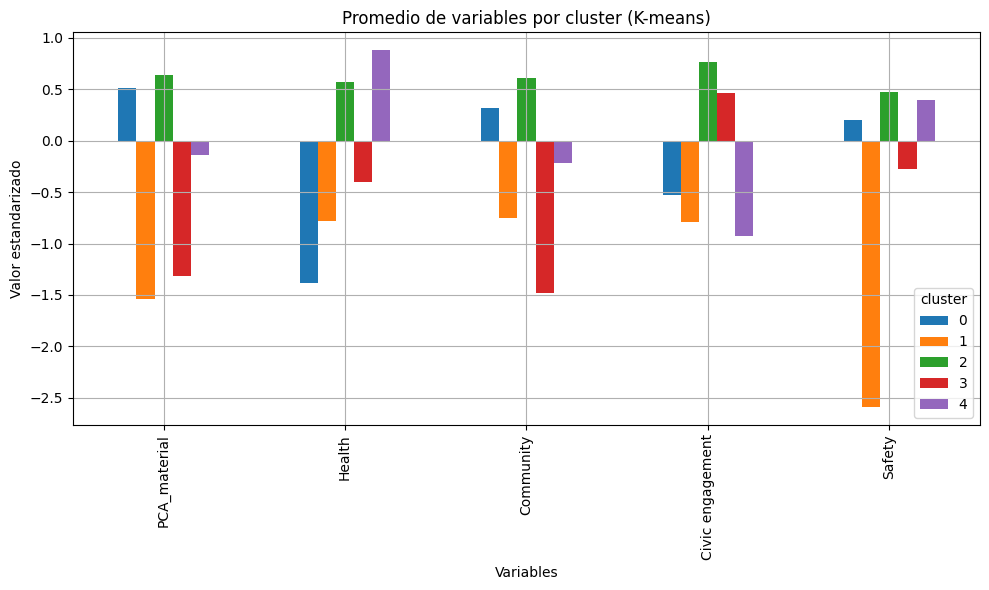

In [27]:
# Promedios clusters K means
promedios_cluster.T.plot(kind='bar', figsize=(10,6))
plt.title("Promedio de variables por cluster (K-means)")
plt.ylabel("Valor estandarizado")
plt.xlabel("Variables")
plt.grid(True)
plt.tight_layout()
plt.show()

El análisis de los promedios por cluster permite identificar perfiles diferenciados de bienestar entre regiones. La variable PCA_material, que resume condiciones materiales como educación, ingreso, empleo, vivienda y acceso a servicios, presenta valores altos en el Cluster 0 y muy bajos en el Cluster 1, lo que refleja una clara brecha en el acceso a condiciones de vida básicas.

Además, el Cluster 2 se distingue por tener un valor alto en salud (Health) pero no necesariamente en las demás dimensiones, lo que sugiere regiones con buen desempeño sanitario pero con debilidades materiales o cívicas. Por otro lado, el Cluster 1 destaca por su nivel críticamente bajo en seguridad (Safety), siendo el más vulnerable en esa dimensión.

Esta segmentación permite comprender cómo se agrupan las regiones no solo por su satisfacción general, sino por combinaciones específicas de dimensiones materiales y sociales.

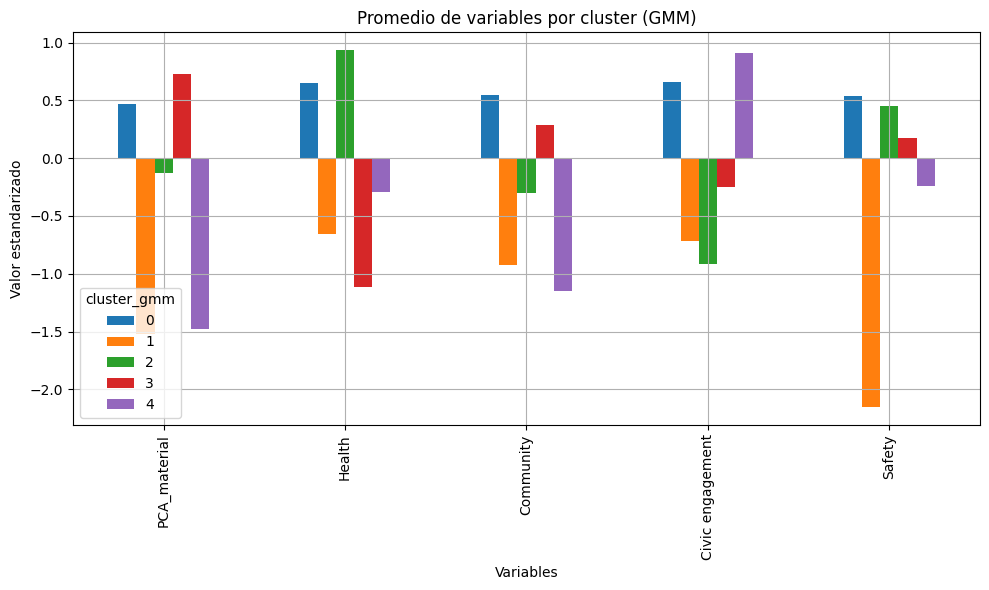

In [28]:
# Promedios de las variables por cluster_gmm
promedios_gmm = df_f1.groupby('cluster_gmm')[columnas_numericas].mean()

# Graficar
promedios_gmm.T.plot(kind='bar', figsize=(10,6))
plt.title("Promedio de variables por cluster (GMM)")
plt.ylabel("Valor estandarizado")
plt.xlabel("Variables")
plt.grid(True)
plt.tight_layout()
plt.show()

#### COMPARACIÓN DE LOS PROMEDIOS DE LAS VARIABLES EN AMBOS MODELOS

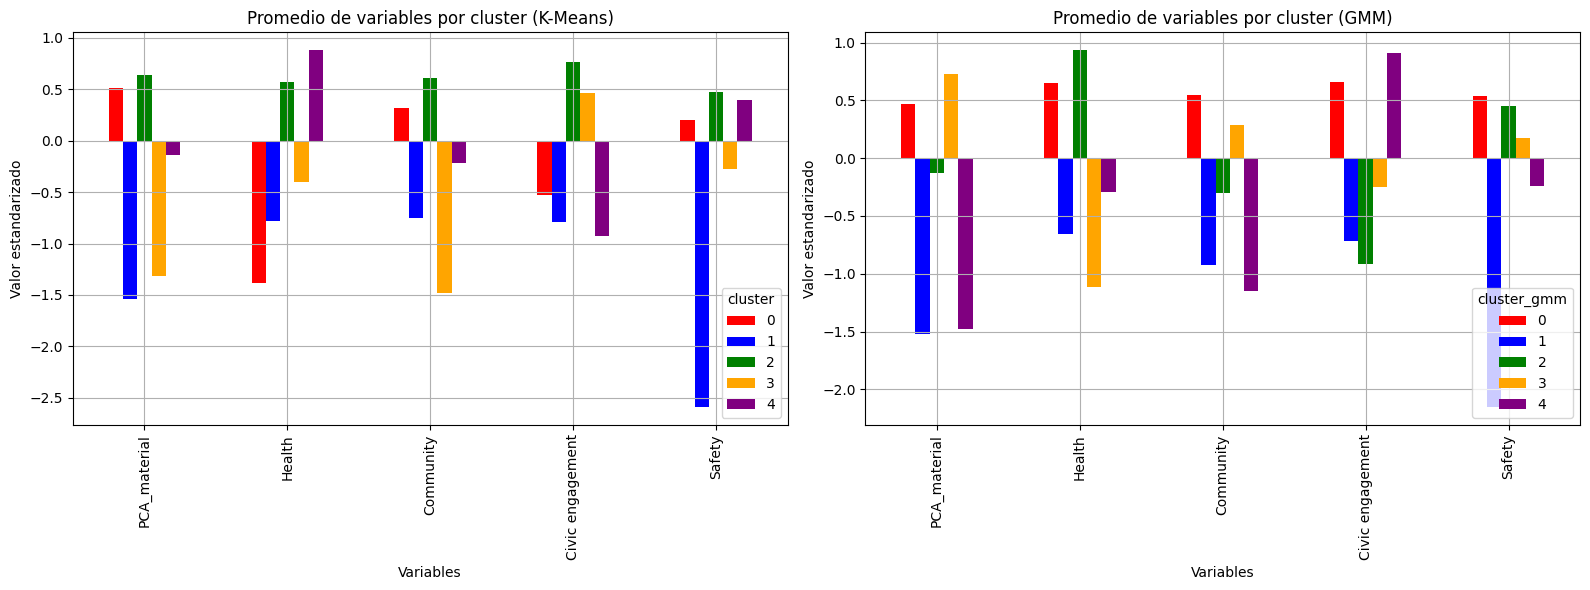

In [29]:
# Definir lista de colores para los clusters 0 a 4
colores_fijos = ["red", "blue", "green", "orange", "purple"]

fig, axs = plt.subplots(1, 2, figsize=(16,6))

# Gráfico para KMeans
promedios_cluster.T.plot(kind='bar', ax=axs[0], color=colores_fijos)
axs[0].set_title("Promedio de variables por cluster (K-Means)")
axs[0].set_ylabel("Valor estandarizado")
axs[0].set_xlabel("Variables")
axs[0].grid(True)

# Gráfico para GMM
promedios_gmm.T.plot(kind='bar', ax=axs[1], color=colores_fijos)
axs[1].set_title("Promedio de variables por cluster (GMM)")
axs[1].set_ylabel("Valor estandarizado")
axs[1].set_xlabel("Variables")
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Explicabilidad e interpretabilidad <a name="seccion6"></a>
Los resultados del aprendizaje no supervisado pueden ser difíciles de interpretar, especialmente al trabajar con estructuras de datos complejas. Las técnicas de visualización y el conocimiento del dominio son cruciales para comprender los hallazgos. Es por eso que en esta sección se incluye:
- Diferencias de los modelos utilizados. 
- Revisamos el conjunto de regiones, países y zonas geográficas de los clusters. 

#### DIFERENCIAS DE LOS MODELOS UTILIZADOS

K-Means y Gaussian Mixture Models (GMM) son dos métodos ampliamente utilizados para análisis de clustering, aunque se basan en enfoques distintos y responden a necesidades diferentes según el tipo de datos y el propósito del análisis.

K-Means es una opción eficiente y fácil de interpretar cuando los grupos en los datos son bien separados y con forma aproximadamente esférica. Su simplicidad lo convierte en una herramienta útil para tareas donde se requiere rapidez y claridad en la interpretación. Sin embargo, su rendimiento disminuye cuando los datos contienen outliers o los clusters tienen formas más complejas.

GMM, en cambio, ofrece mayor flexibilidad al permitir la identificación de grupos con formas elípticas y diferente varianza interna. Gracias a su base probabilística, este modelo puede adaptarse mejor a estructuras más complejas, aunque requiere más recursos computacionales y su interpretación puede ser menos directa.

En definitiva, no hay un algoritmo superior en términos absolutos. La elección debe basarse en las características del problema. Para datos estructurados de forma sencilla, K-Means es eficaz. Para estructuras más intrincadas, GMM puede capturar mejor la heterogeneidad. Idealmente, se recomienda probar ambos métodos y apoyarse en herramientas como visualizaciones y métricas (como el BIC o el silhouette score) para determinar cuál se ajusta mejor al caso de estudio.

#### INTERPRETACIÓN DE HALLAZGOS según países, región y continentes. 

#### CONSTRUIMOS VARIABLE 'CONTINENTES' 

In [30]:
paises_unicos = df_f1['Country'].drop_duplicates().sort_values()
print(paises_unicos.values)

['Australia' 'Austria' 'Belgium' 'Canada' 'Chile' 'Colombia' 'Costa Rica'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan' 'Korea'
 'Latvia' 'Lithuania' 'Luxembourg' 'Mexico' 'Netherlands' 'New Zealand'
 'Norway' 'Poland' 'Portugal' 'Slovak Republic' 'Slovenia' 'Spain'
 'Sweden' 'Switzerland' 'Türkiye' 'United Kingdom' 'United States']


In [31]:
pais_a_continente = {
    # Oceanía
    'Australia': 'Oceanía',
    'New Zealand': 'Oceanía',

    # América del Norte
    'Canada': 'América del Norte',
    'United States': 'América del Norte',
    'Mexico': 'América del Norte',

    # América Central
    'Costa Rica': 'América Central',

    # América del Sur
    'Chile': 'América del Sur',
    'Colombia': 'América del Sur',

    # Europa
    'Austria': 'Europa',
    'Belgium': 'Europa',
    'Czech Republic': 'Europa',
    'Denmark': 'Europa',
    'Estonia': 'Europa',
    'Finland': 'Europa',
    'France': 'Europa',
    'Germany': 'Europa',
    'Greece': 'Europa',
    'Hungary': 'Europa',
    'Iceland': 'Europa',
    'Ireland': 'Europa',
    'Italy': 'Europa',
    'Latvia': 'Europa',
    'Lithuania': 'Europa',
    'Luxembourg': 'Europa',
    'Netherlands': 'Europa',
    'Norway': 'Europa',
    'Poland': 'Europa',
    'Portugal': 'Europa',
    'Slovak Republic': 'Europa',
    'Slovenia': 'Europa',
    'Spain': 'Europa',
    'Sweden': 'Europa',
    'Switzerland': 'Europa',
    'United Kingdom': 'Europa',

    # Asia Occidental (Medio Oriente)
    'Israel': 'Asia Occidental',
    'Türkiye': 'Asia Occidental',

    # Asia Oriental
    'Japan': 'Asia Oriental',
    'Korea': 'Asia Oriental'
}


In [32]:
df_f1['Continent'] = df_f1['Country'].map(pais_a_continente)

#### PAÍSES POR CLUSTER

In [33]:
# Países por cluster KMeans
for i in sorted(df_f1['cluster'].unique()):
    print(f"\nCluster KMeans {i}:")
    print(df_f1[df_f1['cluster'] == i]['Country'].unique())


Cluster KMeans 0:
['Canada' 'Czech Republic' 'Estonia' 'France' 'Hungary' 'Latvia'
 'Lithuania' 'Poland' 'Portugal' 'Slovak Republic' 'Slovenia'
 'United States']

Cluster KMeans 1:
['Colombia' 'Costa Rica' 'Mexico']

Cluster KMeans 2:
['Australia' 'Austria' 'Belgium' 'Canada' 'Czech Republic' 'Denmark'
 'Estonia' 'Finland' 'France' 'Germany' 'Iceland' 'Ireland' 'Israel'
 'Italy' 'Luxembourg' 'Netherlands' 'New Zealand' 'Norway' 'Spain'
 'Sweden' 'United Kingdom' 'United States']

Cluster KMeans 3:
['Colombia' 'Costa Rica' 'Estonia' 'Greece' 'Italy' 'Mexico' 'Poland'
 'Türkiye' 'United States']

Cluster KMeans 4:
['Chile' 'Colombia' 'Costa Rica' 'Finland' 'France' 'Greece' 'Ireland'
 'Israel' 'Italy' 'Japan' 'Korea' 'Portugal' 'Slovenia' 'Spain'
 'Switzerland' 'United Kingdom' 'United States']


In [34]:
# Países por cluster GMM
for i in sorted(df_f1['cluster_gmm'].unique()):
    print(f"\nCluster GMM {i}:")
    print(df_f1[df_f1['cluster_gmm'] == i]['Country'].unique())


Cluster GMM 0:
['Australia' 'Austria' 'Belgium' 'Canada' 'Czech Republic' 'Denmark'
 'Estonia' 'Finland' 'France' 'Germany' 'Iceland' 'Ireland' 'Israel'
 'Italy' 'Luxembourg' 'Netherlands' 'New Zealand' 'Norway' 'Portugal'
 'Slovenia' 'Spain' 'Sweden' 'United Kingdom']

Cluster GMM 1:
['Colombia' 'Costa Rica' 'Mexico']

Cluster GMM 2:
['Chile' 'Finland' 'France' 'Greece' 'Israel' 'Italy' 'Japan' 'Korea'
 'Portugal' 'Spain' 'Switzerland' 'United States']

Cluster GMM 3:
['Canada' 'Czech Republic' 'Estonia' 'France' 'Hungary' 'Latvia'
 'Lithuania' 'New Zealand' 'Poland' 'Slovak Republic' 'United States']

Cluster GMM 4:
['Colombia' 'Costa Rica' 'France' 'Mexico' 'Türkiye']


| KMeans Cluster | Países (KMeans)                                                                                                                            | GMM Más Similar | Países (GMM)                                                                                                                           |
| -------------- | ------------------------------------------------------------------------------------------------------------------------------------------ | --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| 0              | Canada, Czech Republic, Estonia, France, Hungary, Latvia, Lithuania, Poland, Portugal, Slovak Republic, Slovenia, United States            | 3               | Canada, Czech Republic, Estonia, France, Hungary, Latvia, Lithuania, New Zealand, Poland, Slovak Republic, United States               |
| 1              | Colombia, Costa Rica, Mexico                                                                                                               | 1               | Colombia, Costa Rica, Mexico                                                                                                           |
| 2              | Australia, Austria, Belgium, Canada, Czech Republic, Denmark, Estonia, Finland, France, Germany, Iceland, Ireland, Israel, Italy, etc.     | 0               | Australia, Austria, Belgium, Canada, Czech Republic, Denmark, Estonia, Finland, France, Germany, Iceland, Ireland, Israel, Italy, etc. |
| 3              | Colombia, Costa Rica, Estonia, Greece, Italy, Mexico, Poland, Türkiye, United States                                                       | 4               | Colombia, Costa Rica, France, Mexico, Türkiye                                                                                          |
| 4              | Chile, Colombia, Costa Rica, Finland, France, Greece, Ireland, Israel, Italy, Japan, Korea, Portugal, Slovenia, Spain, Switzerland, UK, US | 2               | Chile, Finland, France, Greece, Israel, Italy, Japan, Korea, Portugal, Spain, Switzerland, United States                               |


#### REGIONES POR CLUSTER

In [35]:
## Por región cluster KMeans
for i in sorted(df_f1['cluster'].unique()):
    print(f"\nCluster Kmeans {i}:")
    print(df_f1[df_f1['cluster'] == i][['Country', 'Region']].drop_duplicates())


Cluster Kmeans 0:
            Country                   Region
31           Canada    Northwest Territories
32           Canada                  Nunavut
89   Czech Republic  Central Bohemian Region
90   Czech Republic                Southwest
91   Czech Republic                Northwest
..              ...                      ...
437   United States             South Dakota
438   United States                Tennessee
439   United States                    Texas
444   United States            West Virginia
446   United States                  Wyoming

[85 rows x 2 columns]

Cluster Kmeans 1:
        Country              Region
49     Colombia           Antioquia
50     Colombia           Atlántico
52     Colombia             Bolívar
55     Colombia             Caquetá
56     Colombia               Cauca
57     Colombia               Cesar
60     Colombia               Chocó
61     Colombia               Huila
63     Colombia           Magdalena
64     Colombia                Meta
66 

In [36]:
## Por región cluster GMM
for i in sorted(df_f1['cluster_gmm'].unique()):
    print(f"\nCluster GMM {i}:")
    print(df_f1[df_f1['cluster_gmm'] == i][['Country', 'Region']].drop_duplicates())


Cluster GMM 0:
            Country              Region
0         Australia     New South Wales
1         Australia            Victoria
2         Australia          Queensland
3         Australia     South Australia
4         Australia   Western Australia
..              ...                 ...
391  United Kingdom  South East England
392  United Kingdom  South West England
393  United Kingdom               Wales
394  United Kingdom            Scotland
395  United Kingdom    Northern Ireland

[162 rows x 2 columns]

Cluster GMM 1:
      Country                   Region
49   Colombia                Antioquia
50   Colombia                Atlántico
51   Colombia  Bogotá Capital District
52   Colombia                  Bolívar
54   Colombia                   Caldas
..        ...                      ...
258    Mexico                  Tabasco
259    Mexico               Tamaulipas
261    Mexico                 Veracruz
262    Mexico                  Yucatan
263    Mexico                Zacate

#### CONTINENTES POR CLUSTERS

In [37]:
# Continentes por cluster KMeans
for i in sorted(df_f1['cluster'].unique()):
    print(f"\nCluster KMeans {i}:")
    continentes = df_f1[df_f1['cluster'] == i]['Continent'].drop_duplicates()
    print(continentes.values)


Cluster KMeans 0:
['América del Norte' 'Europa']

Cluster KMeans 1:
['América del Sur' 'América Central' 'América del Norte']

Cluster KMeans 2:
['Oceanía' 'Europa' 'América del Norte' 'Asia Occidental']

Cluster KMeans 3:
['América del Sur' 'América Central' 'Europa' 'América del Norte'
 'Asia Occidental']

Cluster KMeans 4:
['América del Sur' 'América Central' 'Europa' 'Asia Occidental'
 'Asia Oriental' 'América del Norte']


In [38]:
# Continentes por cluster GMM
for i in sorted(df_f1['cluster_gmm'].unique()):
    print(f"\nCluster GMM {i}:")
    continentes = df_f1[df_f1['cluster_gmm'] == i]['Continent'].drop_duplicates()
    print(continentes.values)


Cluster GMM 0:
['Oceanía' 'Europa' 'América del Norte' 'Asia Occidental']

Cluster GMM 1:
['América del Sur' 'América Central' 'América del Norte']

Cluster GMM 2:
['América del Sur' 'Europa' 'Asia Occidental' 'Asia Oriental'
 'América del Norte']

Cluster GMM 3:
['América del Norte' 'Europa' 'Oceanía']

Cluster GMM 4:
['América del Sur' 'América Central' 'Europa' 'América del Norte'
 'Asia Occidental']


#### PAÍSES, REGIONES Y CONTINENTES POR CLUSTERS

In [39]:
# Regiones, país y Continente cluster K Means
for i in sorted(df_f1['cluster'].unique()):
    print(f"\nCluster KMeans {i}:")
    print(df_f1[df_f1['cluster'] == i][['Country', 'Region', 'Continent']].drop_duplicates())


Cluster KMeans 0:
            Country                   Region          Continent
31           Canada    Northwest Territories  América del Norte
32           Canada                  Nunavut  América del Norte
89   Czech Republic  Central Bohemian Region             Europa
90   Czech Republic                Southwest             Europa
91   Czech Republic                Northwest             Europa
..              ...                      ...                ...
437   United States             South Dakota  América del Norte
438   United States                Tennessee  América del Norte
439   United States                    Texas  América del Norte
444   United States            West Virginia  América del Norte
446   United States                  Wyoming  América del Norte

[85 rows x 3 columns]

Cluster KMeans 1:
        Country              Region          Continent
49     Colombia           Antioquia    América del Sur
50     Colombia           Atlántico    América del Sur
52    

In [40]:
# Regiones, país y Continente cluster GMM
for i in sorted(df_f1['cluster_gmm'].unique()):
    print(f"\nCluster GMM {i}:")
    print(df_f1[df_f1['cluster_gmm'] == i][['Country', 'Region', 'Continent']].drop_duplicates())


Cluster GMM 0:
            Country              Region Continent
0         Australia     New South Wales   Oceanía
1         Australia            Victoria   Oceanía
2         Australia          Queensland   Oceanía
3         Australia     South Australia   Oceanía
4         Australia   Western Australia   Oceanía
..              ...                 ...       ...
391  United Kingdom  South East England    Europa
392  United Kingdom  South West England    Europa
393  United Kingdom               Wales    Europa
394  United Kingdom            Scotland    Europa
395  United Kingdom    Northern Ireland    Europa

[162 rows x 3 columns]

Cluster GMM 1:
      Country                   Region          Continent
49   Colombia                Antioquia    América del Sur
50   Colombia                Atlántico    América del Sur
51   Colombia  Bogotá Capital District    América del Sur
52   Colombia                  Bolívar    América del Sur
54   Colombia                   Caldas    América del 

#### DISCUSIÓN: COMPARACIÓN CON VARIABLE AUTODECLARADA 'LIFE SATISFACTION' SEGÚN CLUSTERS

In [41]:
df_f1 = df_f1.merge(df_mod[['Code', 'Life satisfaction']], on='Code', how='left')

In [42]:
# K Means: Promedio de satisfacción por cluster
print("\nPromedio de satisfacción por cluster KMeans:")
df_f1.groupby('cluster')['Life satisfaction'].mean().sort_values(ascending=False)


Promedio de satisfacción por cluster KMeans:


cluster
2    7.901314
0    5.812871
4    5.169711
1    4.386957
3    2.279322
Name: Life satisfaction, dtype: float64

In [43]:
# GMM: Promedio de satisfacción por cluster
print("\nPromedio de satisfacción por cluster GMM:")
df_f1.groupby('cluster_gmm')['Life satisfaction'].mean().sort_values(ascending=False)


Promedio de satisfacción por cluster GMM:


cluster_gmm
0    7.650617
3    6.342191
2    4.975921
1    4.254098
4    1.862001
Name: Life satisfaction, dtype: float64

Tabla comparativa entre los modelos y la variable auto-reportada 'Life Satisfaction' del índice: 
|cluster KMeans | Mean LS KMeans | Símil cluster GMM | Mean LS GMM  |
|---------------|----------------|-------------------|--------------|
|       0       |   5.812871     |      3            |  6.342191    |
|       1       |   4.386957     |      1            |  4.254098    |
|       2       |   7.901314     |      0            |  7.650617    |
|       3       |   2.279322     |      4            |  1.862001    |
|       4       |   5.169711     |      2            |  4.975921    |

Se observa que ambos modelos permiten identificar grupos coherentes con distintos niveles de bienestar subjetivo, lo que respalda su utilidad como herramientas de clasificación en contextos sociales. Además, la coherencia entre modelos y la variable Life Satisfaction sugiere que los clusters construidos a partir de variables objetivas capturan de manera razonable diferencias subjetivas entre grupos poblacionales. Las diferencias entre cada modelo pueden deberse a la forma en que GMM modela distribuciones elípticas con diferentes varianzas, a diferencia de KMeans que asume una forma esférica y equidistante en sus particiones.

Es relevante destacar que en este caso GMM podría ofrecer una representación ligeramente más precisa de la distribución del bienestar subjetivo, debido a su flexibilidad estadística, aunque KMeans continúa siendo una alternativa interpretativamente más simple y computacionalmente más eficiente.

### Extenciones y futuros estudios
Una posible extensión de este trabajo consiste en modelar la variable de bienestar subjetivo, Life Satisfaction, como variable dependiente en un enfoque predictivo. Para ello, pueden emplearse métodos de regresión tradicionales y técnicas avanzadas de aprendizaje automático, como Random Forest, que permitan capturar relaciones no lineales y efectos de interacción entre variables. El objetivo sería evaluar en qué medida las dimensiones objetivas del bienestar —tales como el nivel educacional, los ingresos, la calidad de la vivienda, la salud, entre otras— permiten explicar o anticipar la autoevaluación del bienestar por parte de los individuos. Este análisis contribuiría a identificar los factores con mayor peso relativo en la formación de la percepción subjetiva de bienestar, ofreciendo así información útil para la formulación de políticas públicas centradas en el ciudadano.

In [44]:
#test de ANOVA KMeans
from scipy.stats import f_oneway, kruskal

# Agrupar datos por cluster
grupos = [df_f1[df_f1['cluster'] == i]['Life satisfaction'].dropna() for i in sorted(df_f1['cluster'].unique())]

# Prueba ANOVA
anova = f_oneway(*grupos)
print("ANOVA:", anova)

# Prueba no paramétrica si ANOVA no es válido
kruskal_test = kruskal(*grupos)
print("Kruskal-Wallis:", kruskal_test)


ANOVA: F_onewayResult(statistic=np.float64(99.80351236885606), pvalue=np.float64(1.8146547738423423e-60))
Kruskal-Wallis: KruskalResult(statistic=np.float64(199.20162193079946), pvalue=np.float64(5.578518611126079e-42))


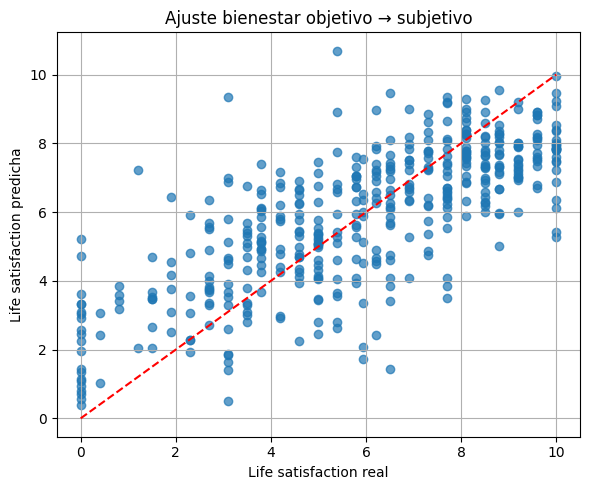

el coeficiente de PCA_materials es 1.4800424424986267
el coeficiente de Health es 0.4561873227958874
el coeficiente de Community es 1.0094392914207913
el coeficiente de Civic engagement es -0.06025385357810942
el coeficiente de Safety es -0.5963794353273753
el intercepto es 5.931350114416478
R^2: 56.416590544379154 %


In [45]:
# Regresión imputando valores faltantes con la media
from sklearn.linear_model import LinearRegression

# Definimos las variables explicativas
X = df_f1[['PCA_material','Health', 'Community', 'Civic engagement', 'Safety']].copy()
X = X.fillna(X.mean())

# Variable dependiente
y = df_f1['Life satisfaction'].fillna(df_f1['Life satisfaction'].mean())

# Ajuste del modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Resultados
coeficientes = modelo.coef_
intercepto = modelo.intercept_
r2 = modelo.score(X, y)

# Predicción
y_pred = modelo.predict(X)

# Gráfico del ajuste
plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Life satisfaction real')
plt.ylabel('Life satisfaction predicha')
plt.title('Ajuste bienestar objetivo → subjetivo')
plt.grid(True)
plt.tight_layout()
plt.show()

print('el coeficiente de PCA_materials es', coeficientes[0])
print('el coeficiente de Health es', coeficientes[1])
print('el coeficiente de Community es', coeficientes[2])
print('el coeficiente de Civic engagement es', coeficientes[3])
print('el coeficiente de Safety es', coeficientes[4])
print('el intercepto es', intercepto)
print('R^2:', r2*100, '%')


| Variable             | Coeficiente | Interpretación                                                                                                                                                                                                      |
| -------------------- | ----------: | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **PCA\_material**    |   **+1.48** | Es la variable **más influyente**. Regiones con mejor bienestar material tienden a reportar mayor satisfacción de vida. Esto valida el uso del componente principal como síntesis estructural.                      |
| **Community**        |       +1.01 | También muy relevante. La cohesión y relaciones sociales son fuertemente predictoras de la satisfacción subjetiva.                                                                                                  |
| **Health**           |       +0.46 | La salud percibida tiene una contribución positiva importante.                                                                                                                                                      |
| **Civic engagement** |       -0.06 | Efecto casi neutro. La participación cívica no parece estar asociada directamente al bienestar subjetivo en este modelo.                                                                                            |
| **Safety**           |   **-0.60** | Resultado interesante: mayor seguridad objetiva se asocia con menor satisfacción. Esto puede indicar tensiones culturales o percepción de sobreprotección/inseguridad latente no explicada por los datos objetivos. |


En general, los resultados confirman que existe una relación significativa entre bienestar objetivo (variables dependientes) y subjetivo (variable independiente), pero esta relación no es perfecta. Se necesitará más investigación. Se puede apreciar que elementos estructurales como el bienestar material, la salud y las relaciones sociales (comunidad) se traducen en una mayor satisfacción con la vida, validando parcialmente el clustering realizado previamente. Sin embargo, la aparente disonancia en variables como seguridad o participación cívica subraya que el bienestar subjetivo también responde a elementos culturales, expectativas o emociones no observables. Según el análisis, en contextos altamente seguros, la población puede esperar altos estándares en otras dimensiones del bienestar —como salud mental, comunidad o participación cívica— que, si están insatisfechas, reducen la percepción general de satisfacción. En otras palabras, cuando la seguridad está garantizada, ya no es un factor diferencial de felicidad.